In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


/Users/nick/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
data = pd.read_csv("../processing/merged_data.csv", index_col=[0])
data.head()

0  1  2  3  5  6  7  8  9  10  ...  componentindex_246.0  \
1.0  0  1  0  1  0  0  1  1  0   0  ...                     1   
2.0  0  1  1  1  0  0  1  1  0   0  ...                     0   
3.0  0  1  1  1  0  0  1  1  0   0  ...                     0   
4.0  0  1  1  1  0  0  1  1  0   0  ...                     1   
5.0  0  1  1  1  0  0  1  1  1   1  ...                     0   

     componentindex_251.0  time_point  infection_status  gut_section_AM  \
1.0                     1           0                 0               1   
2.0                     1           0                 0               0   
3.0                     1           0                 0               0   
4.0                     1           0                 0               1   
5.0                     1           0                 0               0   

     gut_section_H  gut_section_PM  R.prolixus_starved  T.cruzi_epi  \
1.0              0               0                   0            0   
2.0              0               1                   0            0   
3.0              1               0                   0            0   
4.0              0               0                   0            0   
5.0              0               1                   0            0   

     T.cruzi_tryp  
1.0             1  
2.0             1  
3.0             1  
4.0             1  
5.0             1  

[5 rows x 932 columns]

In [3]:
def crossval(features, target, nfolds=5, nruns=100):
    
    np.random.seed(0)
    foldseeds = np.random.randint(10*nruns,size=nruns)
    
    params = {'objective': 'binary', 'metric': 'auc', 'random_state': 0}
    
    norm = nfolds*nruns
    
    feat_vals = features.values
    
    if len(feat_vals.shape)==1:
        feat_vals = np.reshape(feat_vals, (-1,1))
    
    shap_values = np.zeros((feat_vals.shape[0],feat_vals.shape[1]+1))
    
    aucs = []
    accs = []
    
    for run in range(nruns):
        
        CV = KFold(n_splits=nfolds, shuffle=True, random_state=foldseeds[run])
        
        auc = 0.
        acc = 0.

        for train_index, test_index in CV.split(feat_vals):
    
            X_tr, X_tst = feat_vals[train_index], feat_vals[test_index]
            y_tr, y_tst = target.iloc[train_index], target.iloc[test_index]
    
            train_set = lgb.Dataset(X_tr, label=y_tr)
            valid_set = lgb.Dataset(X_tst, label=y_tst, reference=train_set)
    
            bst = lgb.train(params, train_set, num_boost_round=250, valid_sets=[train_set, valid_set],
                            early_stopping_rounds=50, verbose_eval=False)
    
            probs = bst.predict(X_tst, num_iteration=bst.best_iteration)
            classes = np.heaviside(probs - 0.5, 1).astype(int)
    
            auc += roc_auc_score(y_tst, probs)/nfolds
            acc += accuracy_score(y_tst, classes)/nfolds
    
            explainer = shap.TreeExplainer(bst)
            shap_values = explainer.shap_values(data2)
        
        aucs.append(auc)
        accs.append(acc)
        
    aucs = np.array(aucs)
    accs = np.array(accs)
    
    return aucs, accs, shap_values, explainer, bst

In [4]:
target = data.infection_status
data2 = data.drop(['infection_status'], axis=1)
data2.head()

0  1  2  3  5  6  7  8  9  10  ...  componentindex_238.0  \
1.0  0  1  0  1  0  0  1  1  0   0  ...                     0   
2.0  0  1  1  1  0  0  1  1  0   0  ...                     0   
3.0  0  1  1  1  0  0  1  1  0   0  ...                     0   
4.0  0  1  1  1  0  0  1  1  0   0  ...                     1   
5.0  0  1  1  1  0  0  1  1  1   1  ...                     0   

     componentindex_246.0  componentindex_251.0  time_point  gut_section_AM  \
1.0                     1                     1           0               1   
2.0                     0                     1           0               0   
3.0                     0                     1           0               0   
4.0                     1                     1           0               1   
5.0                     0                     1           0               0   

     gut_section_H  gut_section_PM  R.prolixus_starved  T.cruzi_epi  \
1.0              0               0                   0            0   
2.0              0               1                   0            0   
3.0              1               0                   0            0   
4.0              0               0                   0            0   
5.0              0               1                   0            0   

     T.cruzi_tryp  
1.0             1  
2.0             1  
3.0             1  
4.0             1  
5.0             1  

[5 rows x 931 columns]

In [5]:
aucs, accs, shaps, explainer, gbm_model = crossval(data2, target)

In [6]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

mean AUC: 0.988249
std AUC: 0.005585
mean accuracy: 0.918497
std accuracy: 0.016100


Here we're looking at the best model, not a random one

In [7]:
preds = gbm_model.predict(data2)
pred_classes = np.heaviside(preds - 0.5, 1).astype(int)
tn, fp, fn, tp = confusion_matrix(target, pred_classes).ravel()
(tn, fp, fn, tp)

(89, 1, 1, 80)

With this method we've returned an average accuracy of around 92%, which isn't bad, but unfortunately no improvement over logistic regression. Let's try and explain the output of the last built model using shap.

SHAP is a package that can explain the output of any machine learning model, so we're going to use it for consistancy across our different models.

## SHAP feature explanations

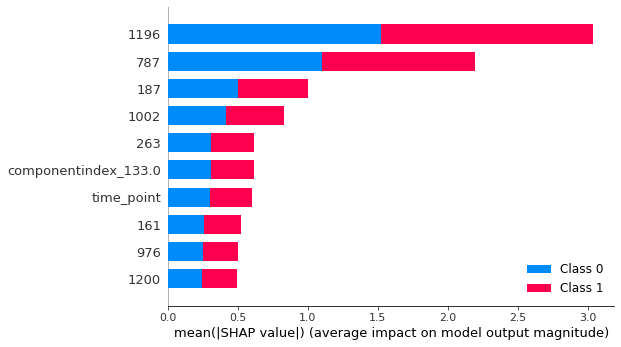

In [8]:
shap.summary_plot(shaps, data2, max_display=10)

Similar to the logistic regression results, we see that the same metabolites are having an impact on the model output. Let's take a look at a random sample in more detail.

In [9]:
#select row 18
data2.loc[[18]]

0  1  2  3  5  6  7  8  9  10  ...  componentindex_238.0  \
18  0  1  1  1  0  0  1  1  0   0  ...                     0   

    componentindex_246.0  componentindex_251.0  time_point  gut_section_AM  \
18                     0                     0           1               0   

    gut_section_H  gut_section_PM  R.prolixus_starved  T.cruzi_epi  \
18              1               0                   0            0   

    T.cruzi_tryp  
18             1  

[1 rows x 931 columns]

In [10]:
chosen_instance = data2.loc[[118]]
shap_values = explainer.shap_values(chosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], chosen_instance)




We see above the impact that the presence (=1) or absence (=0) of all features has on the final output value. So here the absence of 1196 is increasing the likelihood that it is exposed to infected blood, while the absence of 787 is decreasing that likelihood. It's a cool output, I like it. Let's take a peak at what this value was originally.

In [11]:
target.loc[[118]]

118    1
Name: infection_status, dtype: int64

It was negative so this sample was predicted correctly. Cool.

There's another nice output that I'd like to take a look at. This one can group samples by similarity and we can look at the impact that any given feature is having. 

In [12]:
shap_values = explainer.shap_values(data2)
shap.force_plot(explainer.expected_value[1], shap_values[1], data2, link="logit")


For example, we select 1196 above and see that when it is absent (blue) there is a bigger effect in a smaller number of samples.

We're going to select the top 25 features from this model and combine all of our outputs later to see which features are worth trying to:
1. elucidate the structure of in the case of a metabolite, but mostly;
2. identify based on the data we have.


In [13]:
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(data2.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance = feature_importance[:25]
feature_importance.to_csv('GB_top25.csv')

In [14]:
len(sum(vals))

931

In [15]:
feature_importance

col_name  feature_importance_vals
714                  1196               259.927967
557                   787               187.831556
135                   187                85.797950
668                  1002                70.792206
189                   263                52.315632
896  componentindex_133.0                52.229038
924            time_point                51.468464
116                   161                44.408128
654                   976                42.692106
717                  1200                41.980332
513                   717                35.408105
186                   260                32.586067
645                   956                30.729727
14                     16                28.000366
644                   952                27.509015
47                     63                22.939625
61                     81                21.987623
82                    112                21.896760
929           T.cruzi_epi                21.785877
136                   189                20.909254
648                   959                20.312050
876   componentindex_76.0                19.833528
149                   205                18.385504
451                   636                16.364397
415                   579                16.063278